In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import validation_curve, learning_curve, cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler, normalize

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.feature_selection import SelectPercentile, VarianceThreshold

from sklearn.metrics import accuracy_score, f1_score, silhouette_samples, silhouette_score

import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from time import time
import matplotlib
matplotlib.rc('figure', figsize=[10,5])

# random state
rs = 142


data import of 2 datasets:
1. online shopper intention (18 features)
2. generated 

In [2]:
# import dataset 1
df = pd.read_csv("datasets/online_shoppers_intention.csv")

# VisitorType -> New_Visitor is 0, Returning_Visitor is 1 (drop rows with "Other" because value is unspecified)
df.drop(df[df.VisitorType == "Other"].index, inplace=True)
df.loc[df["VisitorType"] == "New_Visitor", "VisitorType"] = True
df.loc[df["VisitorType"] == "Returning_Visitor", "VisitorType"] = False
df.drop(columns=['Month'], inplace=True)

# split into train, validation and testing sets
x_data1 = df.iloc[:, :-1]
y_data1 = df.iloc[:, -1 ] # Revenue is class label
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_data1, y_data1, test_size = 0.2, random_state = rs, shuffle = True)

Implement 2 clustering algorithms:
1. k-means clustering (KMeans)
2. Expectation Maximization (GaussianMixture)

For n_clusters = 2 The average silhouette_score is : 0.781018030088178
For n_clusters = 3 The average silhouette_score is : 0.6944832362347948
For n_clusters = 4 The average silhouette_score is : 0.6757047845019836
For n_clusters = 5 The average silhouette_score is : 0.6216376133428353
For n_clusters = 6 The average silhouette_score is : 0.6051911226062056
For n_clusters = 7 The average silhouette_score is : 0.5890478097266355
For n_clusters = 8 The average silhouette_score is : 0.5638512328406237
For n_clusters = 9 The average silhouette_score is : 0.541097902561051
For n_clusters = 10 The average silhouette_score is : 0.5172957618703141
For n_clusters = 20 The average silhouette_score is : 0.43789704062959867
For n_clusters = 25 The average silhouette_score is : 0.41910168797010083
For n_clusters = 50 The average silhouette_score is : 0.3888637969201496
For n_clusters = 75 The average silhouette_score is : 0.37512199320713757
For n_clusters = 100 The average silhouette_score is : 0.3

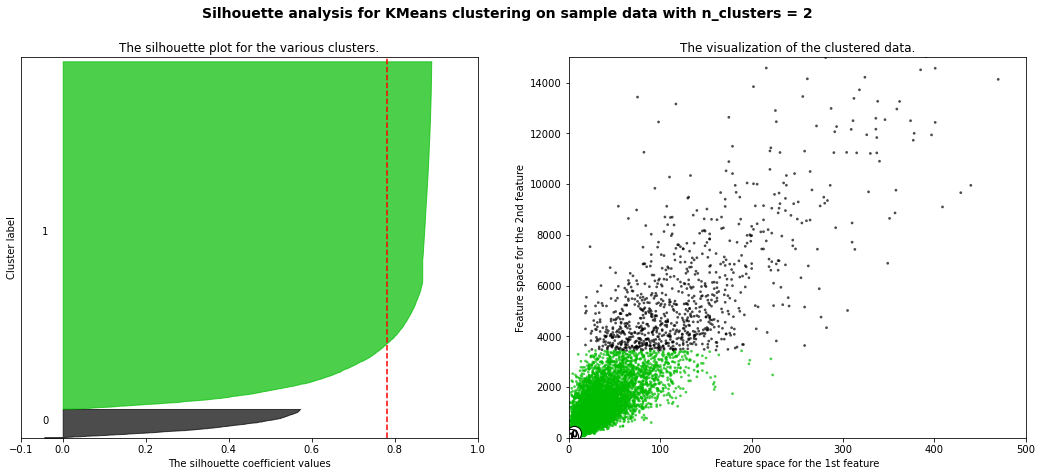

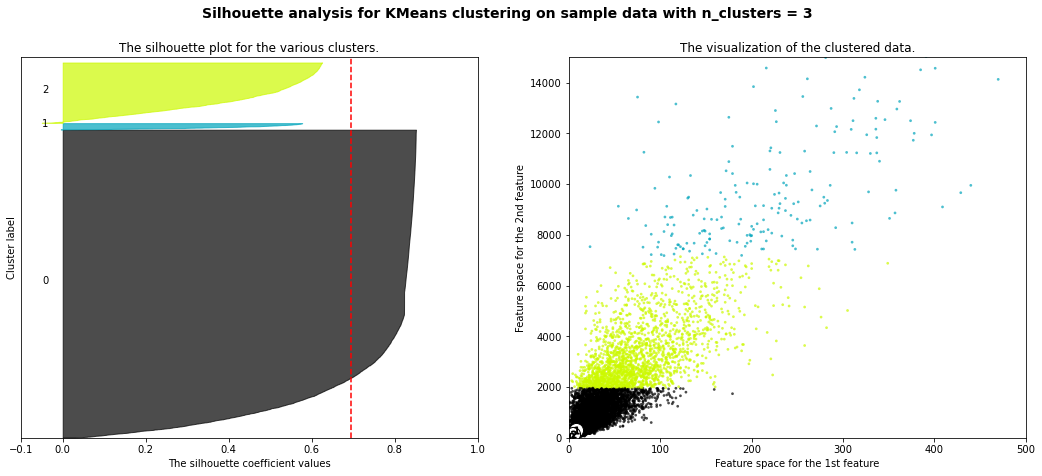

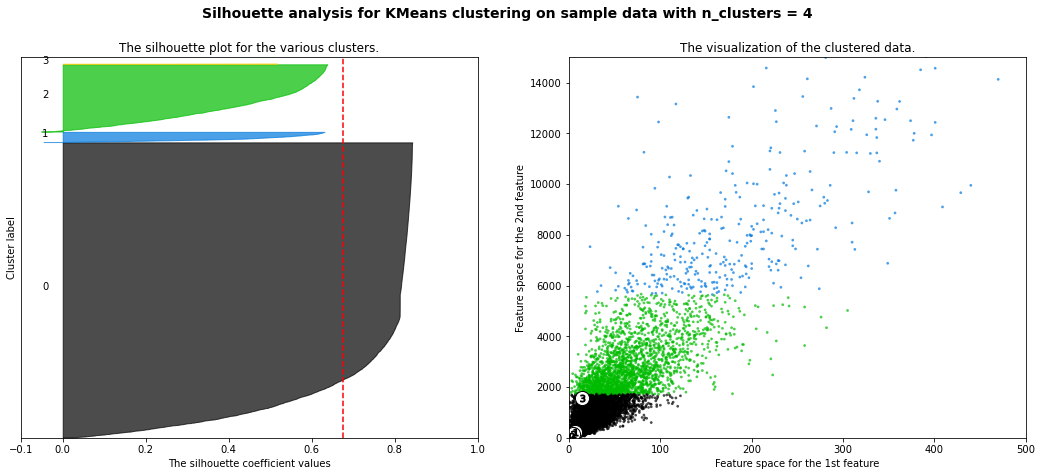

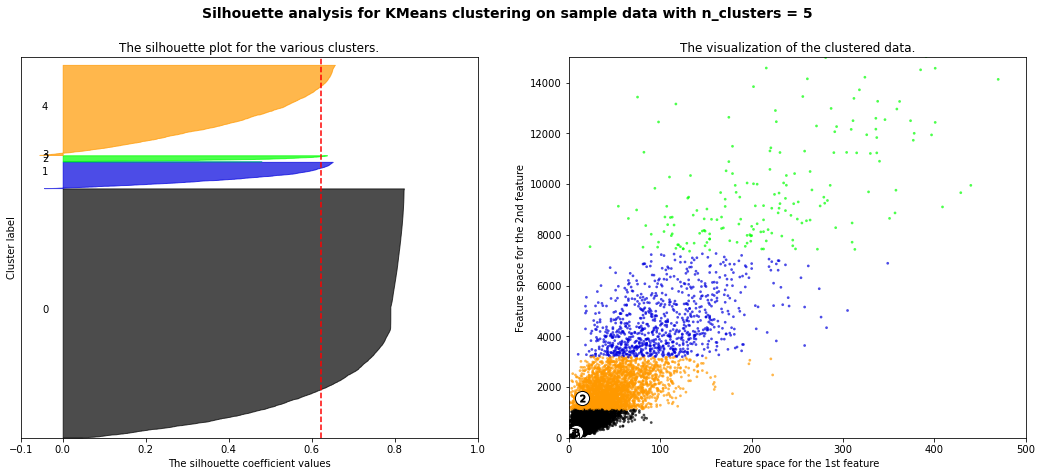

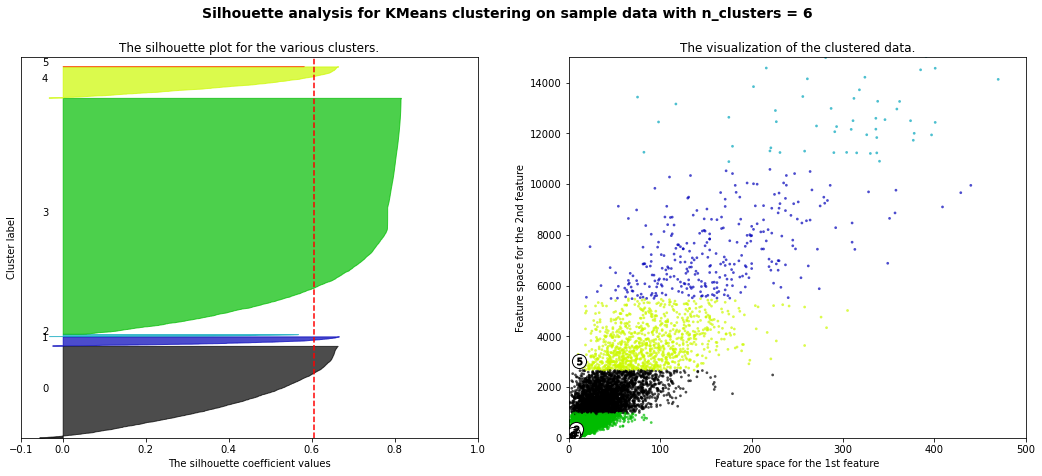

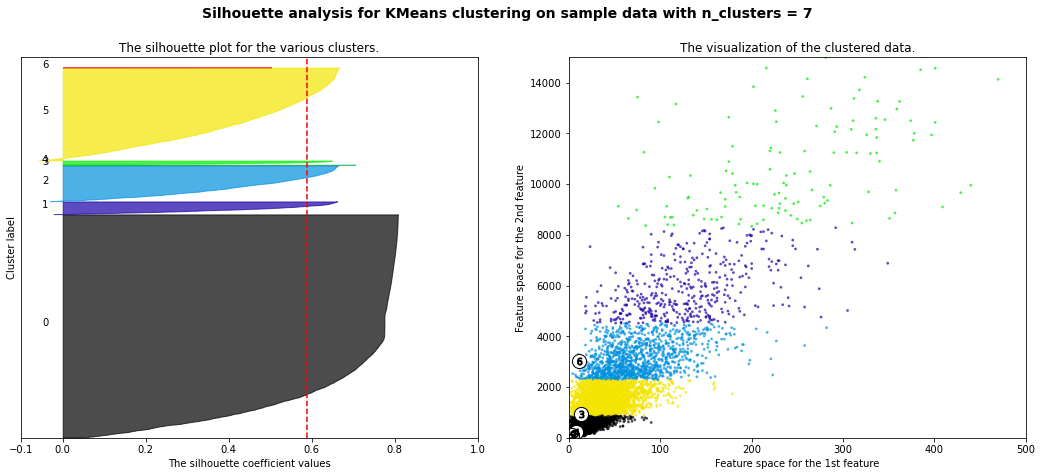

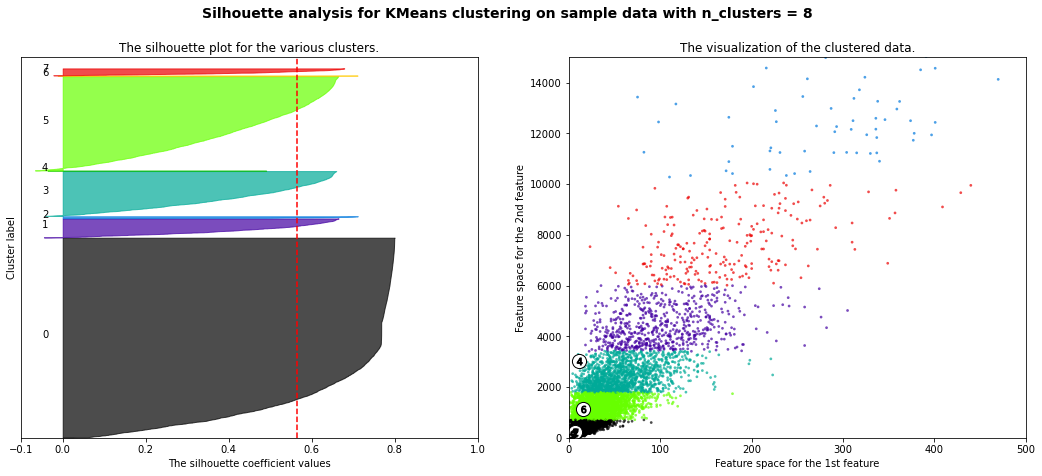

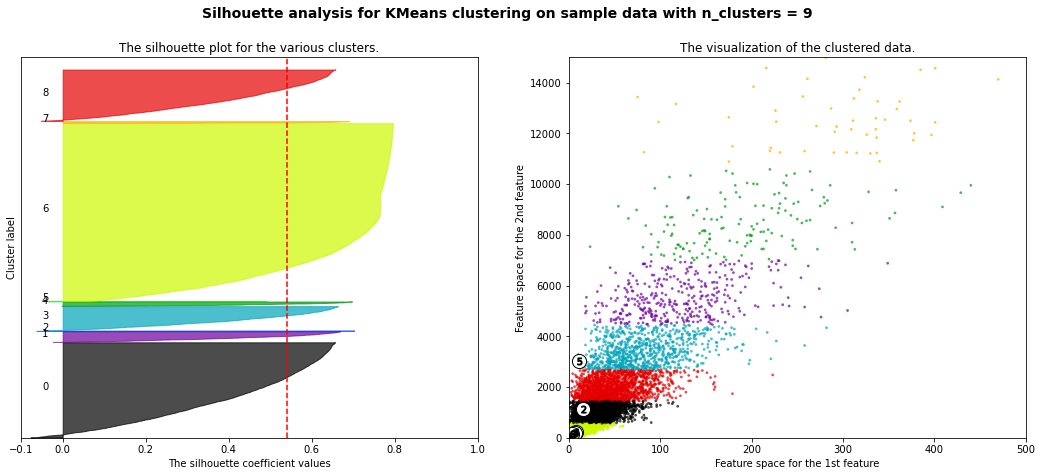

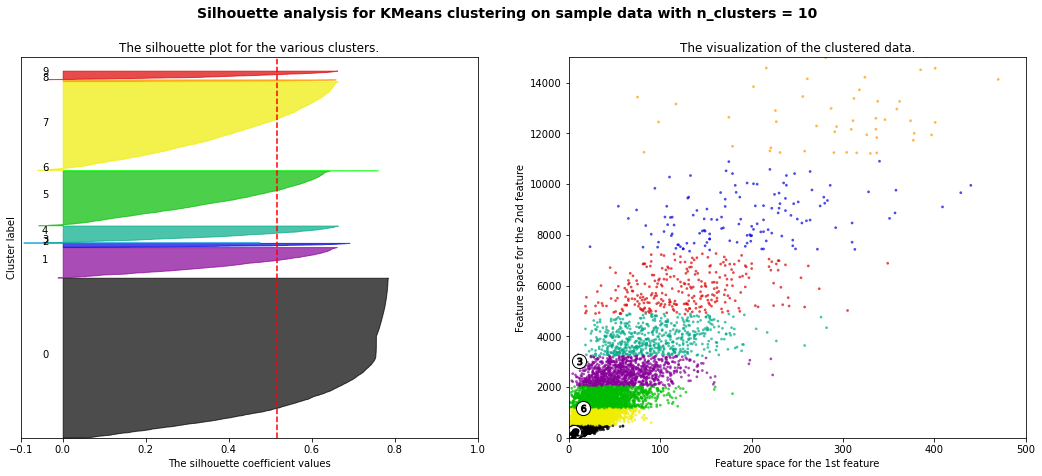

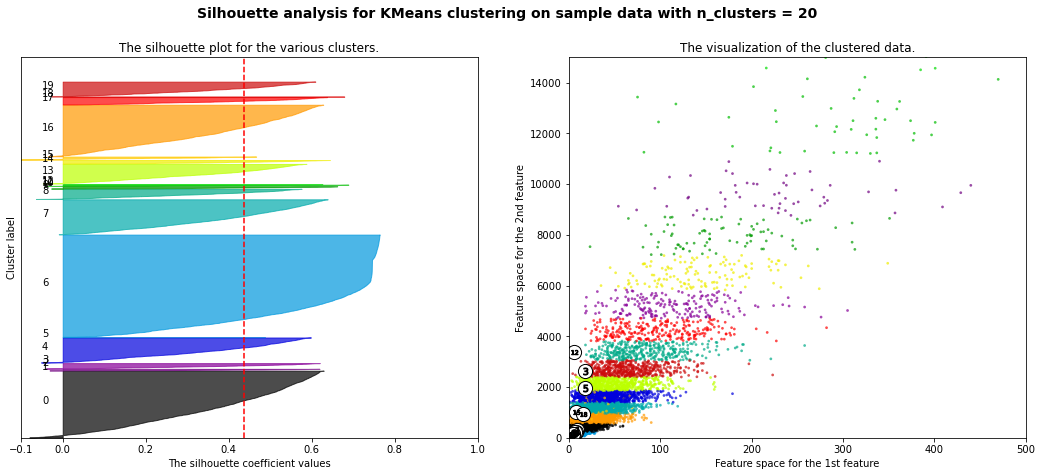

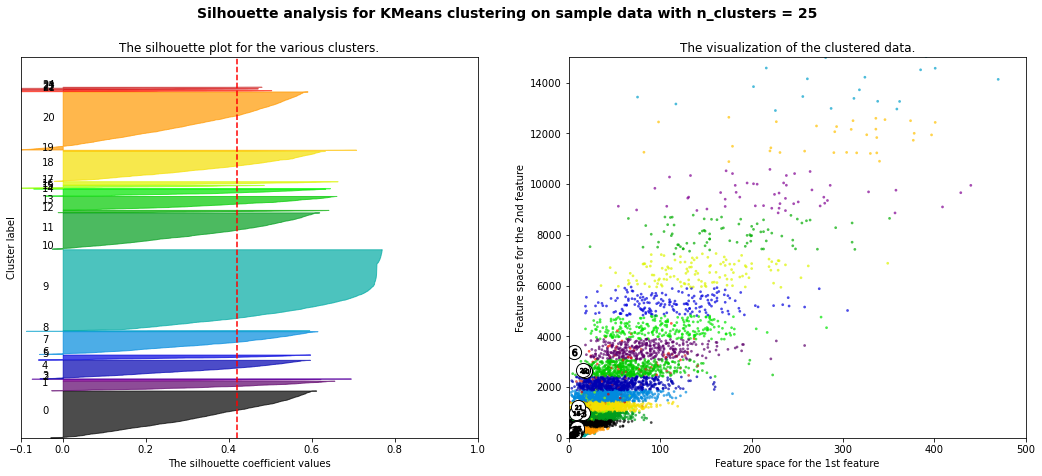

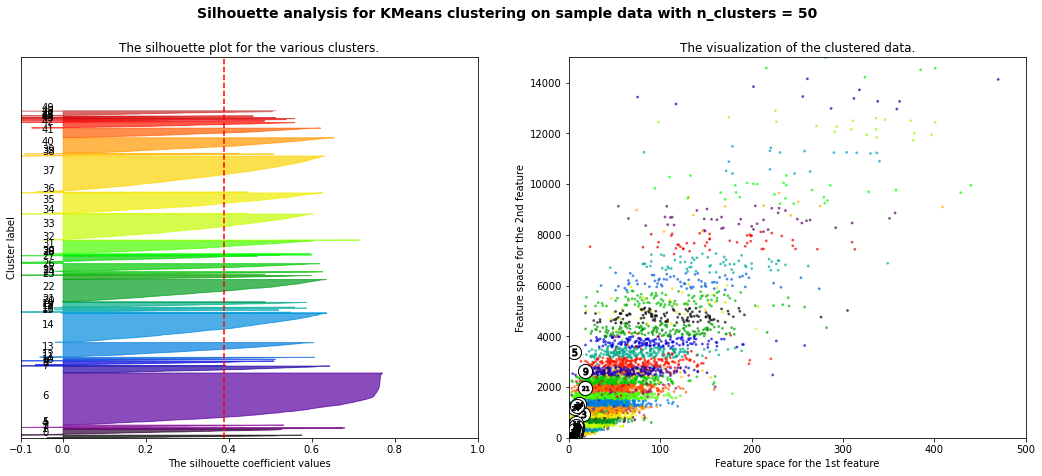

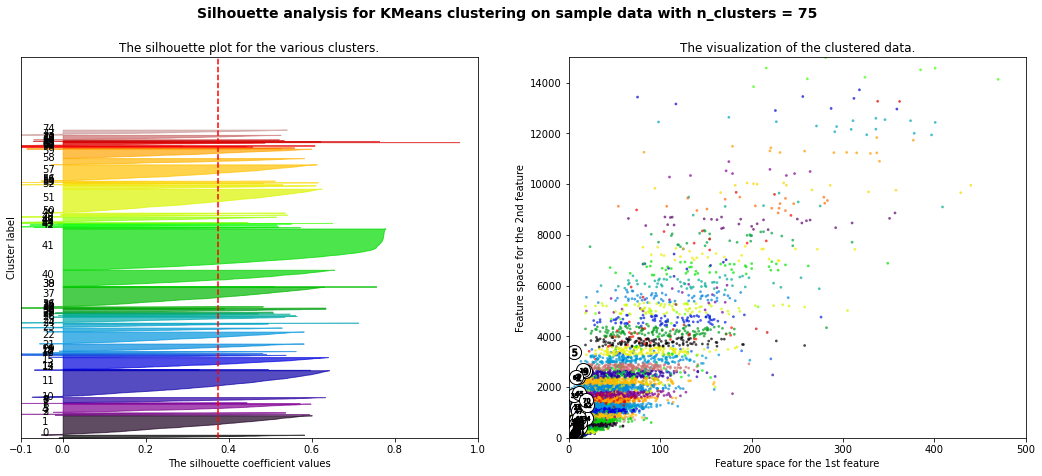

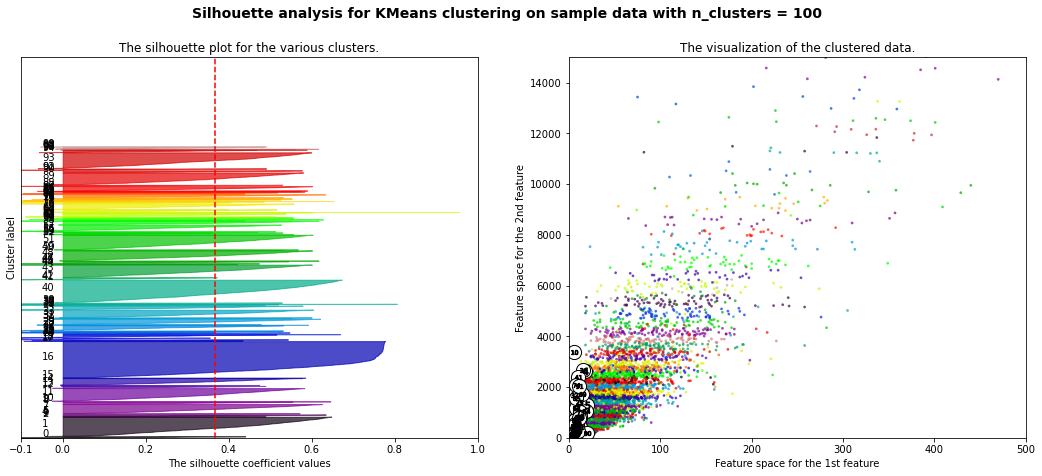

In [3]:
# KMeans
#  select best number of clusters using silhouette plot

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 25, 50, 75, 100]
times = []
sil_scores = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_data1) + (n_clusters + 1) * 50])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=rs)
    
    t0 = time()
    clusterer.fit(x_data1)
    t=time()-t0
    times.append(t)
    
    cluster_labels = clusterer.predict(x_data1)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_data1, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    sil_scores.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_data1, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        x_data1.iloc[:, 4], x_data1.iloc[:, 5], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )
    ax2.set_xlim([0, 500])
    ax2.set_ylim([0, 15000])
    
    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

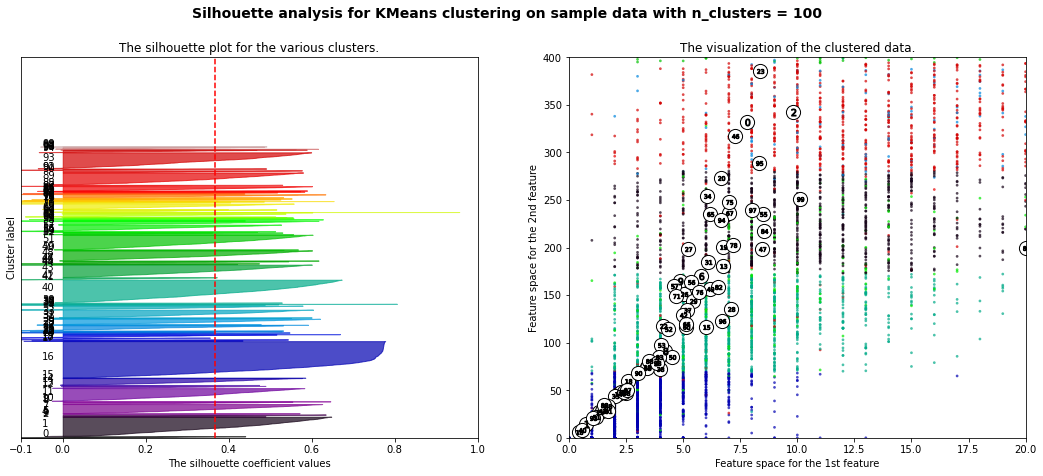

In [4]:
ax2.set_xlim([0, 20])
ax2.set_ylim([0, 400])
fig.gca()
fig

ValueError: x and y must have same first dimension, but have shapes (1,) and (14,)

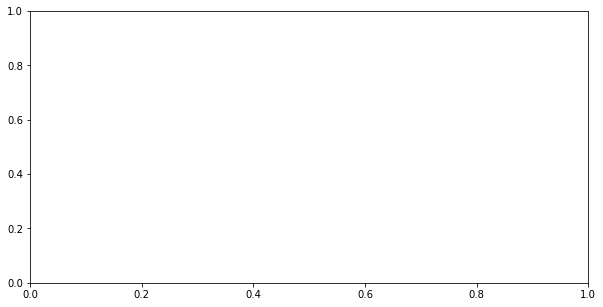

In [5]:
plt.plot(n_clusters, sil_scores)
plt.xlabel('n_clusters')
plt.ylabel('Average silhouette score')
plt.show()

Implement 4 dimensionality reduction algorithms:
1. PCA (PCA)
2. ICA (FastICA)
3. Randomized Projections (GaussianRandomProjection)
4. another feature selection algorithm ()
